# Assignment for practical work 4. Basics of neural networks

Group:

*  Jannik Bucher
*  Dennis Imhof

### Using dataset: Page Blocks Dataset
[Page Blocks Dataset](https://archive.ics.uci.edu/ml/datasets/Page+Blocks+Classification)

## General Assignment

Before performing the practical work, you need download the data set accordingly to the option on your machine
1. Write a program that splits the original sample into a training set and a test set (training set, validation set, test set)
2. Build a model using Perceptron (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) and MLPClassifier (http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). On the basis of experiments, select values for learning rate, the regularization parameter, the optimization function.
3. Build learning curves for better explanation of your experiments.

## Options
Data sets are taken from the UCI Machine Learning Repository
https://archive.ics.uci.edu/ml/
The option is determined by the data set, which can be downloaded from the link above:
The option is determined by the data set, which can be downloaded from the link above:
1. Sponge
2. Water Treatment Plant
3. Synthetic Control Chart Time Series
4. Character Trajectories
5. Plants
6. Libras Movement
7. KEGG Metabolic Relation Network (Directed)
8. SMS Spam Collection
9. seeds
10. Human Activity Recognition Using Smartphones
11. User Knowledge Modeling
12. NYSK
13. Activities of Daily Living (ADLs) Recognition Using Binary Sensors
14. Dresses_Attribute_Sales
15. Wholesale customers
16. StoneFlakes
17. Gesture Phase Segmentation
18. AAAI 2014 Accepted Papers
19. Dow Jones Index
20. AAAI 2013 Accepted Papers
21. wiki4HE
22. Folio
23. Mice Protein Expression
24. Improved Spiral Test Using Digitized Graphics Tablet for Monitoring Parkinson’s Disease


In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [29]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(9,9))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [30]:
def plot_validation_curve(estimator, title, X, y, param_name, param_range, scoring="accuracy"):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=3, scoring=scoring, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    
    best_test_param = param_range[np.argmax(test_scores_mean)]
    best_train_param = param_range[np.argmax(train_scores_mean)]

    best_test_score = np.max(test_scores_mean)
    best_train_score = np.max(train_scores_mean)
    
    
    plt.figure(figsize=(9,9))
    plt.title("Validation Curve {}: {} vs {}\nBest train param: {} - score: {}\nBest test param: {} - score {}".format(title, 
                                                                                                                       scoring, 
                                                                                                                       param_name, 
                                                                                                                       best_train_param, 
                                                                                                                       best_train_score, 
                                                                                                                       best_test_param,
                                                                                                                       best_test_score))
    plt.xlabel("{}".format(param_name))
    plt.ylabel("{}".format(scoring))
    #plt.ylim(0.1, 0.4)
    plt.axvline(best_test_param, color='darkorange', linestyle='--', label="best train param")
    plt.axvline(best_train_param, color='navy', linestyle='--', label="best test param")
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

# Page-Blocks dataset

In [31]:
elements = []
with open('data/page-blocks.data') as f:
    for l in f:       
        elements.append([float(x) for x in l.split()])
        
elements = np.array(elements)

In [32]:
columns = ['height', 
           'lenght', 
           'area',
           'eccen',
           'p_black',
           'p_and',
           'mean_tr',
           'blackpix',
           'blackand',
           'wb_trans',
           'block']

In [33]:
df = pd.DataFrame(elements, columns=columns)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("block", axis=1), df["block"], train_size=0.7, random_state=42)

In [35]:
X_train.describe()

,height,lenght,area,eccen,p_black,p_and,mean_tr,blackpix,blackand,wb_trans
count,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000
mean,10.168102,88.115636,1182.607935,13.197051,0.367214,0.785362,6.415409,354.974158,725.282172,105.078831
std,14.038977,114.094530,4999.354600,29.384528,0.176054,0.170014,81.630229,1302.946891,1912.952788,162.250784
min,1.000000,1.000000,7.000000,0.007000,0.052000,0.062000,1.000000,7.000000,7.000000,1.000000
25%,7.000000,17.000000,112.000000,2.111000,0.261000,0.680500,1.610000,42.000000,94.000000,17.000000
50%,8.000000,40.000000,320.000000,5.111000,0.337000,0.804000,2.070000,105.000000,246.000000,48.000000
75%,10.000000,104.000000,960.000000,13.309500,0.424000,0.925000,2.990000,278.000000,698.500000,123.000000
max,311.000000,553.000000,143993.000000,413.000000,1.000000,1.000000,4955.000000,33017.000000,46133.000000,3212.000000


## Normalizing the data

In [36]:
scale = StandardScaler()

In [37]:
X_train_scaled = pd.DataFrame(scale.fit_transform(X_train), columns=X_train.columns)

# Perceptron

## Comparing performance of scaled and unscaled data

#### Unscaled inputs

In [38]:
cv_scores = cross_val_score(Perceptron(random_state=42), X_train, y_train, cv=5, n_jobs=-1, scoring="accuracy")
cv_scores

array([0.93237971, 0.73307292, 0.67232376, 0.91361257, 0.93193717])

In [39]:
np.mean(cv_scores)

0.836665225718372

#### Scaled inputs

In [40]:
cv_scores = cross_val_score(Perceptron(random_state=42), X_train_scaled, y_train, cv=5, n_jobs=-1, scoring="accuracy")
cv_scores

array([0.90117035, 0.94270833, 0.96605744, 0.95287958, 0.94240838])

In [41]:
np.mean(cv_scores)

0.9410448167614224

The (unoptimized) model performs much better with the scaled inputs. We will therefore use the scaled inputs for further analysis.

## Tuning hyperparameters
As we've seen above the cross-validation accuracy of both models is already pretty high (94%-97%). Let's see how much we can improve the models by tuning hyperparameters. 

In [42]:
param_perc_dist = {"penalty":[None, 'l1', 'l2', 'elasticnet'],
              "alpha":np.logspace(-7, 0, 30),
              "max_iter" : np.arange(100,2000, 200),
              "eta0": [0.1, 0.5, 1]}

In [43]:
rand_perc = RandomizedSearchCV(Perceptron(random_state=42), param_distributions=param_perc_dist, n_iter=500, scoring="accuracy", cv=3, verbose=1, random_state=42)

In [44]:
rand_perc.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   24.1s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Perceptron(alpha=0.0001, class_weight=None,
                                        early_stopping=False, eta0=1.0,
                                        fit_intercept=True, max_iter=1000,
                                        n_iter_no_change=5, n_jobs=None,
                                        penalty=None, random_state=42,
                                        shuffle=True, tol=0.001,
                                        validation_fraction=0.1, verbose=0,
                                        warm_start=False),
                   iid='warn', n_iter=500, n_jobs=None,
                   param_dist...
       6.72335754e-03, 1.17210230e-02, 2.04335972e-02, 3.56224789e-02,
       6.21016942e-02, 1.08263673e-01, 1.88739182e-01, 3.29034456e-01,
       5.73615251e-01, 1.00000000e+00]),
                                        'eta0': [0.1, 0.5, 1],
                                        'ma

In [45]:
perc_best_penalty, perc_best_max_iter = rand_perc.best_params_['penalty'], rand_perc.best_params_['max_iter']

In [46]:
rand_perc.best_params_, rand_perc.best_score_

({'penalty': 'l1',
  'max_iter': 1300,
  'eta0': 0.5,
  'alpha': 2.8072162039411756e-06},
 0.9556251631427826)

Out of those 2500 fits the 'l2' regularization and max_iter=1700 come out as most favourable. We will now look a bit closer at eta0, the learning rate, and alpha, the constant multiplying the regularization term.

In [47]:
param_perc_grid = {'alpha':np.logspace(-7,0, 50),
              'eta0':np.logspace(-5,0, 30)}
grid_perc = GridSearchCV(Perceptron(penalty=perc_best_penalty, max_iter=perc_best_max_iter, random_state=42), param_grid=param_perc_grid, scoring="accuracy", n_jobs=-1, cv=5)

In [48]:
grid_perc.fit(X_train_scaled, y_train)

/home/den/anaconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Perceptron(alpha=0.0001, class_weight=None,
                                  early_stopping=False, eta0=1.0,
                                  fit_intercept=True, max_iter=1300,
                                  n_iter_no_change=5, n_jobs=None, penalty='l1',
                                  random_state=42, shuffle=True, tol=0.001,
                                  validation_fraction=0.1, verbose=0,
                                  warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([1....
       4.52035366e-03, 6.21016942e-03, 8.53167852e-03, 1.17210230e-02,
       1.61026203e-02, 2.21221629e-02, 3.03919538e-02, 4.17531894e-02,
       5.73615251e-02, 7.88046282e-02, 1.08263673e-01, 1.48735211e-01,
       2.04335972e-01, 2.80721620e-01, 3.85662042e-01, 5.29831691e-01,
       7.27895384e-01, 1.00000000e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_

In [49]:
perc_best_alpha, perc_best_eta0 = grid_perc.best_params_['alpha'], grid_perc.best_params_['eta0']

In [50]:
grid_perc.best_params_, grid_perc.best_score_

({'alpha': 0.00019306977288832496, 'eta0': 0.1082636733874054},
 0.953275907073871)

## Validation curves

Performing an exhaustive grid search over eta0 and alpha lead to slightly different parameters and an increase in accuracy of 0.1%. Let's look at validation curves for both parameters independently.

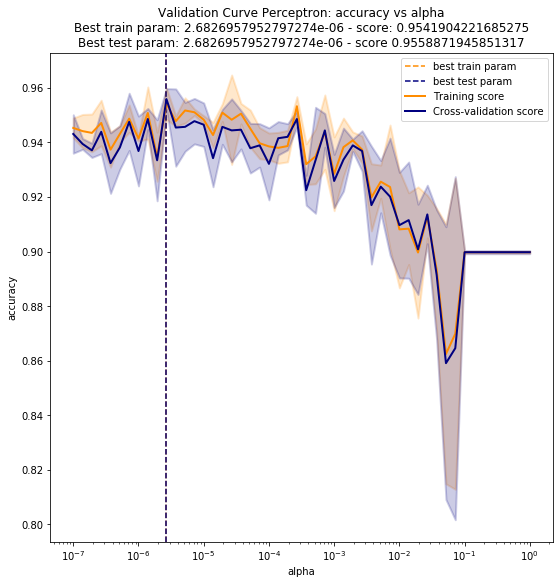

In [51]:
plot_validation_curve(Perceptron(penalty=perc_best_penalty, 
                                 alpha=perc_best_eta0,
                                 max_iter=perc_best_max_iter,
                                 random_state=42), "Perceptron", X_train_scaled, y_train, "alpha", param_perc_grid['alpha'])

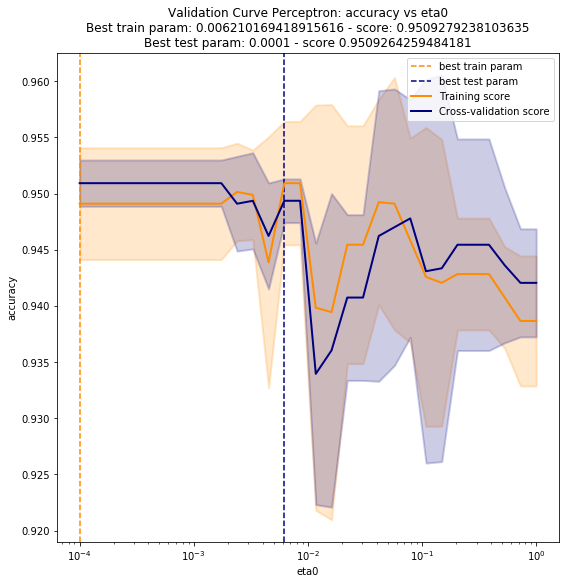

In [52]:
plot_validation_curve(Perceptron(penalty=perc_best_penalty, 
                                 alpha=perc_best_alpha,
                                 max_iter=perc_best_max_iter,
                                 random_state=42), "Perceptron", X_train_scaled, y_train, "eta0", param_perc_grid['eta0'])

## Learning curve

Let's take a look at the learning curve using the best parameters found through RandomizedSearchCV and GridSearchCV.

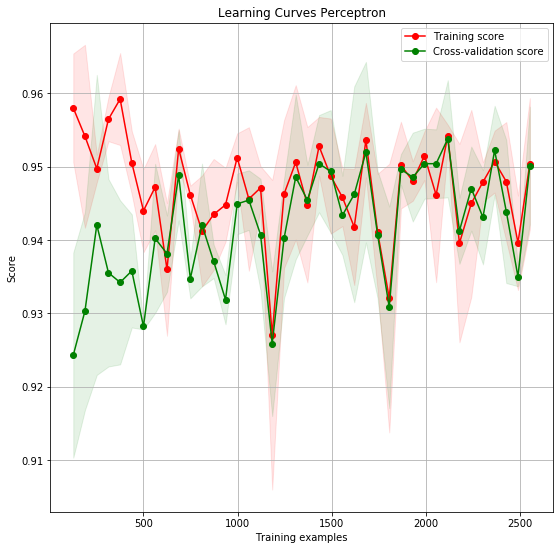

In [53]:
perc = Perceptron(random_state=42,
                  penalty=perc_best_penalty, 
                  alpha=perc_best_alpha, 
                  eta0=perc_best_eta0, 
                  max_iter=perc_best_max_iter)
plot_learning_curve(perc, "Learning Curves Perceptron", X_train_scaled, y_train, cv=3, n_jobs=-1, 
                    train_sizes=np.linspace(0.05,1, 40))

plt.show()

We can see the training and test score converge with 94%-95% accuracy. This means that our model is neither underfitted nor overfitted.

The best score we could reach through tuning with GridSearchCV was 95.3% accuracy, which is ~0.3% higher than the Perceptron model with default parameters.

# Multi Layer Perceptron Classifier

#### Unscaled inputs

In [54]:
cv_scores = cross_val_score(MLPClassifier(random_state=42), X_train, y_train, cv=5, n_jobs=-1, scoring="accuracy")
cv_scores

array([0.95058518, 0.96354167, 0.96475196, 0.88612565, 0.96073298])

In [55]:
np.mean(cv_scores)

0.9451474878374662

#### Scaled inputs

In [56]:
cv_scores = cross_val_score(MLPClassifier(random_state=42), X_train_scaled, y_train, cv=5, n_jobs=-1, scoring="accuracy")
cv_scores

array([0.96358908, 0.96223958, 0.97911227, 0.98167539, 0.97120419])

In [57]:
np.mean(cv_scores)

0.9715641025497306

We find that the MLPClassifier like the Perceptron responds to the scaled data with increased accuracy.

## Tuning hyperparameters
As we've seen above the cross-validation accuracy of the model is already pretty high (97.1%). Let's see how much we can improve the model by tuning hyperparameters. Before we start looking at the learning rate and regularization parameter, we will search for a good number of hidden layers and their respective sizes.

#### Find the optimal layer sizes

In [58]:
param_mlp_grid = {'hidden_layer_sizes' : [(x,) for x in np.arange(100, 500, 100)] + [(x,y) for x in np.arange(100, 500, 100) for y in np.arange(100, 500, 200)],
                  'solver': ['lbfgs', 'sgd', 'adam'],
                  'learning_rate': ['constant', 'invscaling', 'adaptive']}

In [ ]:
grid_mlp = GridSearchCV(MLPClassifier(random_state=42), param_grid=param_mlp_grid, scoring="accuracy", cv=3, n_jobs=-1, verbose=5)
grid_mlp.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 17.8min


In [ ]:
mlp_best_hidden_layers, mlp_best_solver = grid_mlp.best_params_['hidden_layer_sizes'], grid_mlp.best_params_['solver']

In [ ]:
grid_mlp.best_params_, grid_mlp.best_score_

Great, a model with 2 hidden layers with 200 and 300 neurons utilizing the ADAM-optimizer results in an accuracy of 97.31% which is 0.2% higher than the default.

### Learning Rate
Let's also see if there is a preferable behaviour of the learning rate

In [ ]:
param_mlp_grid = {'learning_rate' : ["constant", "invscaling", "adaptive"]}
grid_mlp = GridSearchCV(MLPClassifier(hidden_layer_sizes=mlp_best_hidden_layers,
                                       solver=mlp_best_solver,
                                       random_state=42,
                                       verbose=10), 
                         param_grid=param_mlp_grid, 
                         scoring="accuracy", 
                         cv=3, 
                         n_jobs=-1)
grid_mlp.fit(X_train_scaled, y_train)

In [ ]:
mlp_best_learning_rate = grid_mlp.best_params_['learning_rate']

In [ ]:
grid_mlp.best_params_, grid_mlp.best_score_

### Find the optimal regularization parameter
Let us first look at a validation curve for the regularization parameter alpha

In [ ]:
param_mlp_grid = {'alpha' : np.logspace(-6,0, 4)}
plot_validation_curve(MLPClassifier(hidden_layer_sizes=best_hidden_layers,
                                    solver=best_solver,
                                    learning_rate=besbest_hidden_layersate,
                                    random_state=42), "MLPClassifier", X_train_scaled, y_train, "alpha", param_grid['alpha'])

The training and cross-validation accuracy stays relatively the same over the full range of the alphas until both dramatically drop from $10^{-1}$ on.

In [ ]:
param_mlp_grid = {'alpha' : np.logspace(-6,-3, 4)}
grid_mlp = GridSearchCV(MLPClassifier(hidden_layer_sizes=mlp_best_hidden_layers,
                                       solver=mlp_best_solver,
                                       learning_rate=mlp_best_learning_rate,
                                       random_state=42), 
                         param_grid=param_mlp_grid, 
                         scoring="accuracy", 
                         cv=3, 
                         n_jobs=-1)
grid_mlp.fit(X_train_scaled, y_train)

In [ ]:
mlp_best_alpha = grid_mlp.best_params_['alpha']

In [ ]:
grid_mlp.best_params_, grid_mlp.best_score_

### Learning curve

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=mlp_best_hidden_layers,
              learning_rate=mlp_best_learning_rate,
              solver=mlp_best_solver,
              alpha=mlp_best_alpha,
              random_state=42)

plot_learning_curve(mlp, "MLPClassifier", X_train_scaled, y_train, cv=3, n_jobs=-1, 
                    train_sizes=np.linspace(0.05, 1, 10))

plt.show()

We can see that the train and cross-validation scores initially being far apart converge to a difference of about 0.5%-1% accuracy.

# Test scores

In [ ]:
X_test_scaled = scale.fit_transform(X_test)

### Perceptron

In [ ]:
perc.fit(X_train_scaled, y_train)
perc_pred = perc.predict(X_test_scaled)
accuracy_score(y_test, perc_pred)

In [ ]:
print(classification_report(y_test, perc_pred))

### Multi Layer Perceptron

In [ ]:
mlp.fit(X_train_scaled, y_train)
mlp_pred = mlp.predict(X_test_scaled)
accuracy_score(y_test, mlp_pred)

In [ ]:
print(classification_report(y_test, mlp_pred))

### Random Forest and Gradient Boosting

Tuning the hyperparameters and fitting the models took a while. Let's s compare the results of the neural networks with a random forest and the gradient boosting algorithm.

In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
cross_val_score(rf, X_train_scaled, y_train, scoring="accuracy", cv=10, verbose=1)

In [ ]:
rf.fit(X_train_scaled, y_train)

In [ ]:
rf_pred = rf.predict(X_test_scaled)
accuracy_score(y_test, rf_pred)

In [ ]:
print(classification_report(y_test, rf_pred))

### XGBoost

In [ ]:
xgb = GradientBoostingClassifier(n_estimators=100, max_features=5)
cross_val_score(xgb, X_train_scaled, y_train, scoring="accuracy", cv=10, verbose=1)

In [ ]:
xgb.fit(X_train_scaled, y_train)
xgb_pred = xgb.predict(X_test_scaled)
accuracy_score(y_test, xgb_pred)

In [ ]:
print(classification_report(y_test, xgb_pred))

# Conclusion

Though it took a lot longer to tune and train the MLPClassifier it definitly was worth it. Compared to the Perceptron, RandomForest and XGBoost models it performs better in accuracy, precision, recall and F1 score ie. in every single metric.